# OCR from scratch

Let's define the problem.

There is an issue with a PDF reader, can latex be interpreted? Nope.

In [334]:
# How to read PDF

import fitz # install using: pip install PyMuPDF
with fitz.open("files/Fisica/fisica.pdf") as doc:
    text = ""
    for page in doc:
        text += page.get_text()

text[:800]


'Liceo “Carducci” Volterra - Classe 3aB Scientiﬁco - Francesco Daddi - 21 marzo 2011\nEsercizi sul moto circolare uniforme\nEsercizio 1. Un corpo percorre a velocit`a costante una circonferenza di raggio R = 6 m in 8 s. Si determini:\na) il modulo della velocit`a del corpo;\nb) il modulo dell’accelerazione centripeta.\nEsercizio 2. Determinare la velocit`a angolare di un corpo che, muovendosi a velocit`a costante, impiega 39 s per\npercorrere 7 giri e 3/4 su una traiettoria circolare.\nEsercizio 3. a) Calcolare il modulo della velocit`a della Terra nel suo moto attorno al Sole.\nb) Determinare il modulo dell’accelerazione centripeta.\nSi supponga che l’orbita sia perfettamente circolare e il moto uniforme.\nDati: R = 1, 49 · 1011 m ; T = 3, 16 · 107 s.\nEsercizio 4. a) Calcolare il modulo della veloci'

... and there is an issue with Tesseract because we cannot detect latex correctly. Even if we use lang='equ' with the proper [weights](https://tesseract-ocr.github.io/tessdoc/Data-Files#special-data-files)

In [335]:
# https://tesseract-ocr.github.io/tessdoc/Data-Files#special-data-files
import pytesseract
import cv2
import matplotlib.pyplot as plt
import numpy as np

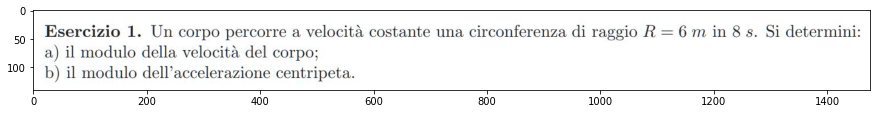

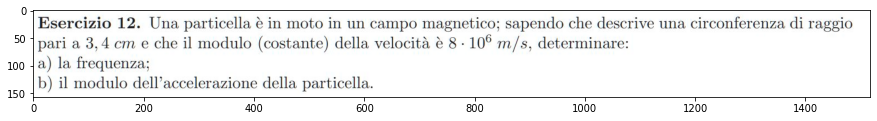

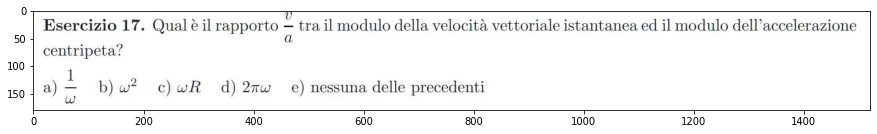

In [336]:
img0 = cv2.imread('files/Fisica/0.jpg')
img1 = cv2.imread('files/Fisica/1.jpg')
img2 = cv2.imread('files/Fisica/2.jpg')

fig = plt.figure(figsize=(15,15))
plt.imshow(img0, cmap='gray')

fig = plt.figure(figsize=(15,15))
plt.imshow(img1, cmap='gray')

fig = plt.figure(figsize=(15,15))
plt.imshow(img2, cmap='gray')

In [337]:
# Print extrated text with tesseract
extracted_text = pytesseract.image_to_string(img0, lang='eng')
print(extracted_text)

extracted_text = pytesseract.image_to_string(img1, lang='eng')
print(extracted_text)

extracted_text = pytesseract.image_to_string(img2, lang='eng')
print(extracted_text)

Esercizio 1. Un corpo percorre a velocita costante una circonferenza di raggio R = 6 m in 8 s. Si determini:
a) il modulo della velocita del corpo;
b) il modulo dell’accelerazione centripeta.

Esercizio 12. Una particella é in moto in un campo magnetico; sapendo che descrive una circonferenza di raggio
pari a 3,4 cm e che il modulo (costante) della velocita @ 8 - 10° m/s, determinare:

a) la frequenza;

b) il modulo dell’accelerazione della particella.

Uv
Esercizio 17. Qual é il rapporto — tra il modulo della velocita vettoriale istantanea ed il modulo dell’accelerazione
a
centripeta?
i

a) — b)w? c)wR 4d) 2zmw  e) nessuna delle precedenti
WwW



Therefore, let's try to build something by us, first of all:
- Convert it to grayscale
- Threshold it using Otsu’s thresholding method

Links not still used but could be useful maybe (?):
- https://medium.com/geekculture/building-a-complete-ocr-engine-from-scratch-in-python-be1fd184753b

In [338]:
# Choose an image that you want to process
img = img2

In [339]:
# # Just for test let's try img_dilation, img_erode. At the moment we didn't use them

# # Taking a matrix of size 5 as the kernel
# kernel = np.ones((5,5), np.uint8)

# img_dilation = cv2.dilate(img, np.ones((1,3), np.uint8), iterations=1)
# fig = plt.figure(figsize=(15,15))
# plt.imshow(img_dilation, cmap='gray')

# img_erode = cv2.erode(img, kernel, iterations=1)

# fig = plt.figure(figsize=(15,15))
# plt.imshow(img_erode, cmap='gray')

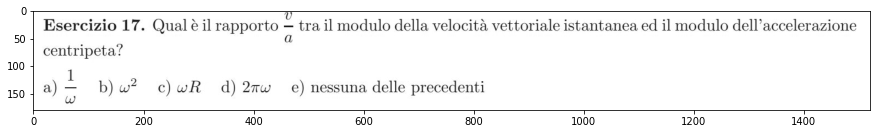

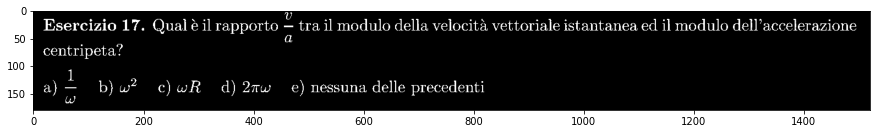

In [340]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fig = plt.figure(figsize=(15,15))
plt.imshow(gray, cmap='gray')

thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
fig = plt.figure(figsize=(15,15))
plt.imshow(thresh, cmap='gray')

In [341]:
# Let's check if thres 0 values and 1 values cover all the images
a = thresh[thresh==0].shape[0]
b = thresh[thresh==255].shape[0]

print(a,b, thresh.mean())

print( (a+b) == (thresh.shape[0] * thresh.shape[1]) )

263114 10666 9.934363357440281
True


Our goal is to apply connected component analysis to filter out these noise regions, leaving us with just the license plate characters.

In [342]:
# apply connected component analysis to the thresholded image
output = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S) # or put 8 instead of 4

(numLabels, labels, stats, centroids) = output
(numLabels, stats, centroids) = (numLabels-1, stats[1::,:], centroids[1::,:]) # exclude background point

In [343]:
idxOrder = centroids[:, 1].argsort()
idxOrder

array([  0,   2,   3,  34,  25,   9,  23,  19,   8,  11,  21,  20,  32,
         5, 102,  62,  58, 108,   1,  30,  12,  10,  16,  31,  33,  18,
        22,   7,  14,  28,  17,  26,  27,  29,  13,   4,  15,  24,  40,
        36,  35,  37,  39,  41,  38,  98,  95,   6, 114,  44,  89, 110,
        45,  63,  50,  59,  75,  78,  43,  86,  99,  76,  90,  77,  66,
        82,  70,  48,  72,  79,  57,  61,  42, 111,  84,  52,  81,  73,
        55,  53,  47,  64,  60, 106,  46,  92,  74,  56,  93, 107, 103,
        83, 104, 100,  96,  91, 112,  85, 113, 105,  68,  54, 101,  69,
        65,  51,  71,  49,  80,  67, 109,  94,  97,  87,  88, 115, 116,
       118, 117, 120, 119, 124, 122, 121, 127, 123, 125, 128, 126, 129,
       130, 145, 131, 159, 160, 147, 171, 163, 136, 142, 141, 144, 143,
       133, 137, 140, 176, 146, 152, 139, 135, 134, 138, 165, 156, 132,
       166, 173, 168, 169, 154, 172, 158, 150, 161, 157, 155, 174, 162,
       175, 170, 164, 148, 167, 153, 149, 151, 177, 178], dtype=

317 16 7 21


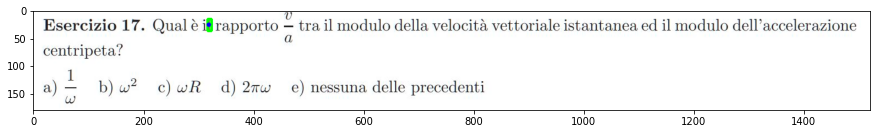

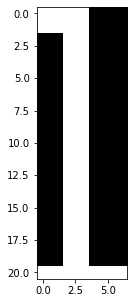

In [344]:
j = 10

output = img.copy()
y = stats[j, cv2.CC_STAT_TOP]
x = stats[j, cv2.CC_STAT_LEFT]
w = stats[j, cv2.CC_STAT_WIDTH]
h = stats[j, cv2.CC_STAT_HEIGHT]
area = stats[j, cv2.CC_STAT_AREA]
(cX, cY) = centroids[j]

# clone our original image (so we can draw on it) and then draw
# a bounding box surrounding the connected component along with
# a circle corresponding to the centroid
cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)

print(x, y, w, h)

fig = plt.figure(figsize=(15,15))
plt.imshow(output)
plt.show()

fig = plt.figure(figsize=(5,5))
plt.imshow(thresh[y:y+h, x:x+w], cmap="gray")
plt.show()

In [345]:
centroids = centroids[idxOrder]
stats = stats[idxOrder]

area = stats[:, cv2.CC_STAT_AREA]
print(area)
area.mean()

[ 53  17  19   9   9   9   8   9  13   9   9  12  16 109   7   9   9  11
 193  66  51  51  51  53  65  69  68  68  52  52  67  67 112 112 108 101
  88  89  58  50  50  50  48  49  49  52  53 171  51  81  47  46  80  60
  66  58  58  58  99  55  55  55  54  49  64  64  66 104  65  65  67  54
  90  65  79  68  68  68  68  69  63  71  69 121  53 121  67  68  76  77
  82  94  79  36  36  36  36  36  83  32  72  69  42  83  79  70  81  80
  84  54  60  60  58 110  98  19  72   9  44  48  50  46  61  55  67  81
  33  70  97   8  56   9  57   1   6   9   9   8 151  51  53  90 108  92
  90  94  42  50  68  52  50  51  51  61  62  52  65  58  54  62  57  56
  39  55  79  62  74  82  80  32  44  58  57  89  72  71  72  12  71]


59.58659217877095

In [346]:
# We are looking for a point that is able to describe a good character for the N-th line
# releated to the area of each char we define a good char the one that has the area greater than the mean of all areas.
def get_good_point(stats):
    area = stats[:, cv2.CC_STAT_AREA]
    areaThres = area.mean()

    for key, val in enumerate(area):
        if val >= areaThres:
            return key

In [347]:
stats[:, cv2.CC_STAT_AREA]

array([ 53,  17,  19,   9,   9,   9,   8,   9,  13,   9,   9,  12,  16,
       109,   7,   9,   9,  11, 193,  66,  51,  51,  51,  53,  65,  69,
        68,  68,  52,  52,  67,  67, 112, 112, 108, 101,  88,  89,  58,
        50,  50,  50,  48,  49,  49,  52,  53, 171,  51,  81,  47,  46,
        80,  60,  66,  58,  58,  58,  99,  55,  55,  55,  54,  49,  64,
        64,  66, 104,  65,  65,  67,  54,  90,  65,  79,  68,  68,  68,
        68,  69,  63,  71,  69, 121,  53, 121,  67,  68,  76,  77,  82,
        94,  79,  36,  36,  36,  36,  36,  83,  32,  72,  69,  42,  83,
        79,  70,  81,  80,  84,  54,  60,  60,  58, 110,  98,  19,  72,
         9,  44,  48,  50,  46,  61,  55,  67,  81,  33,  70,  97,   8,
        56,   9,  57,   1,   6,   9,   9,   8, 151,  51,  53,  90, 108,
        92,  90,  94,  42,  50,  68,  52,  50,  51,  51,  61,  62,  52,
        65,  58,  54,  62,  57,  56,  39,  55,  79,  62,  74,  82,  80,
        32,  44,  58,  57,  89,  72,  71,  72,  12,  71], dtype=

In [348]:
stats.shape

(179, 5)

This is the line: 1.
ValMin is: 13.
Shape of stats: (179, 5).
This is the line: 1.
Shape of stats: (63, 5).
This is the line: 2.
ValMin is: 0.
Shape of stats: (63, 5).
index 1 is out of bounds for axis 0 with size 1
This is the line: 2.
Shape of stats: (62, 5).
This is the line: 3.
ValMin is: 5.
Shape of stats: (62, 5).
This is the line: 3.
Shape of stats: (49, 5).
This is the line: 4.
ValMin is: 8.
Shape of stats: (49, 5).
This is the line: 4.
Shape of stats: (1, 5).
This is the line: 5.
ValMin is: 0.
Shape of stats: (1, 5).
index 1 is out of bounds for axis 0 with size 1
This is the line: 5.
Shape of stats: (0, 5).
The number of detected lines are: 5.


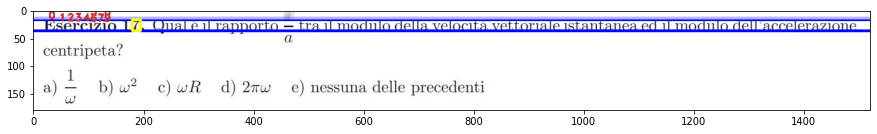

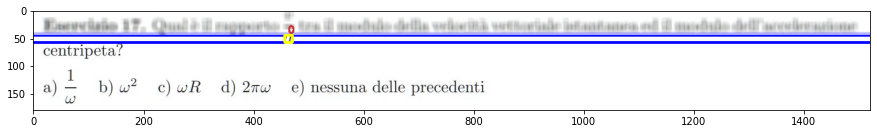

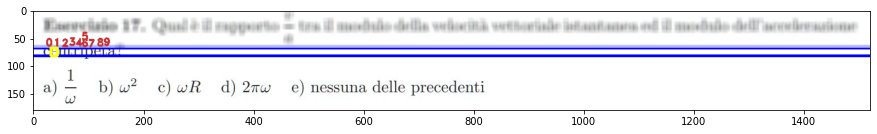

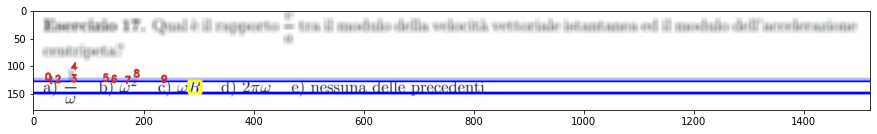

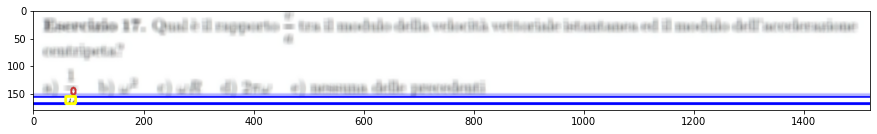

In [349]:
numberLine = 1
centroidsByLine = []
statsByLine = []

lineConstraint = []

while True:

    output = img.copy()

    valMin = get_good_point(stats)


    print(f"This is the line: {numberLine}.")
    print(f"ValMin is: {valMin}.")
    print(f"Shape of stats: {stats.shape}.")
    #print(stats)
    x = stats[valMin, cv2.CC_STAT_LEFT]
    y = stats[valMin, cv2.CC_STAT_TOP]
    w = stats[valMin, cv2.CC_STAT_WIDTH]
    h = stats[valMin, cv2.CC_STAT_HEIGHT]
    area = stats[valMin, cv2.CC_STAT_AREA]

        
    #print(area)
    #cx, cy = centroids[valMin]

    # Top line
    cv2.line(output, (0, y), (output.shape[1], y), (0, 0, 255), thickness=3)
    output[:y,:,:] = cv2.blur(output[:y,:,:], (10,10))

    # Bottom Line
    cv2.line(output, (0, y + h), (output.shape[1], y + h), (0, 0, 255), thickness=3)
    lineConstraint.append( np.array((y, y+h)) )

    # Get index of all centroids that are above the bottom line
    idxMask = centroids[:,1]>(y + h)

    # Order index of the N-th line from left to right
    invertedIdx = np.invert(idxMask)
    centroidsOfThatLine = centroids[invertedIdx]
    statsOfThatLine = stats[invertedIdx]

    # Sort by x component
    idxOrder = centroidsOfThatLine[:, 0].argsort()

    centroidsOfThatLine = centroidsOfThatLine[idxOrder]
    statsOfThatLine = statsOfThatLine[idxOrder]

    centroidsByLine.append(centroidsOfThatLine)
    statsByLine.append(statsOfThatLine)

    # Print only some centroids, not all. Try/except because centroids can be out the image..., this is only to have some visuals
    try:
        for i in range(10):
            (cX, cY) = centroidsOfThatLine[i]
            cv2.putText(output, f"{i}", (int(cX), int(cY)-10), cv2.FONT_HERSHEY_DUPLEX, 0.6, (200, 50, 50), 2)
    except Exception as e:
        print(e)

    # Focus the char used to identify the line
    cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 0), 3)

    fig = plt.figure(figsize=(15,15))
    plt.imshow(output)
    
    centroids = centroids[idxMask]
    stats = stats[idxMask]
    print(f"This is the line: {numberLine}.")
    print(f"Shape of stats: {stats.shape}.")
    #print(stats)

    if centroids.shape[0] < 1:
        break

    numberLine+=1

print(f"The number of detected lines are: {numberLine}.")

Merge lines that are really close

In [350]:
while True:

    bo = True

    for i in range(1, len(lineConstraint)):

        #print(lineConstraint)

        # are they really closer? negative means yes
        val = lineConstraint[i][0] - lineConstraint[i-1][1]

        if val < 0:
            centroidsOfThatLine = np.vstack( (centroidsByLine[i-1], centroidsByLine[i]) )
            statsOfThatLine = np.vstack( (statsByLine[i-1], statsByLine[i]) )

            # Sort by x component
            idxOrder = centroidsOfThatLine[:, 0].argsort()

            # Assign the order by index
            centroidsOfThatLine = centroidsOfThatLine[idxOrder]
            statsOfThatLine = statsOfThatLine[idxOrder]

            # Set new values
            centroidsByLine[i-1] = centroidsOfThatLine
            statsByLine[i-1] = statsOfThatLine

            # Shift the lines
            centroidsByLine[i:] = centroidsByLine[i+1:]
            statsByLine[i:] = statsByLine[i+1:]

            # Shift lineConstraints
            lineConstraint[i-1] = np.array( (min(lineConstraint[i-1][0], lineConstraint[i][0]), max(lineConstraint[i-1][1], lineConstraint[i][1])) )
            lineConstraint[i:] = lineConstraint[i+1:]
            
            bo = False

            break
    
    if bo:
        break

Print new lines!

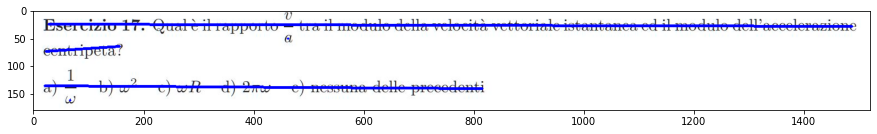

In [351]:
output = img.copy()

for i in range(0, len(centroidsByLine)):
    (cX, cY) = centroidsByLine[i][0]
    (eX, eY) = centroidsByLine[i][-1]
    cv2.line(output, (int(cX), int(cY)), ( int(eX), int(eY)), (0, 0, 255), thickness=3)

# show our output image and connected component mask
fig = plt.figure(figsize=(15,15))
plt.imshow(output)
plt.show()


In [352]:
from IPython.display import clear_output
import time 

In [353]:
def printChar(i, j):

    centroids = centroidsByLine[i]
    nrows, ncols = centroids.shape
    stats = statsByLine[i]

    # clone our original image (so we can draw on it) and then draw
    # a bounding box surrounding the connected component along with
    # a circle corresponding to the centroid
    output = img.copy()

    # print a status message update for the current connected component
    text = f"Examining row {i+1} and component {j}/{nrows}."
    print(f"[INFO] {text}")
    
    # extract the connected component statistics and centroid for
    # the current label
    y = stats[j, cv2.CC_STAT_TOP]
    x = stats[j, cv2.CC_STAT_LEFT]
    w = stats[j, cv2.CC_STAT_WIDTH]
    h = stats[j, cv2.CC_STAT_HEIGHT]
    area = stats[j, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[j]
    print(f"Area={area}")
    print(f"Centroids {cX}, {cY}")
    print(f"y={y}, x={x}, w={w}, h={h}")

    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)

    # show our output image and connected component mask
    fig = plt.figure(figsize=(15,15))
    plt.imshow(output)
    plt.show()

    fig = plt.figure(figsize=(5,5))
    plt.imshow(thresh[y:y+h, x:x+w], cmap="gray")
    plt.show()

[INFO] Examining row 1 and component 15/116.
Area=79
Centroids 247.9493670886076, 29.962025316455698
y=24, x=241, w=15, h=13


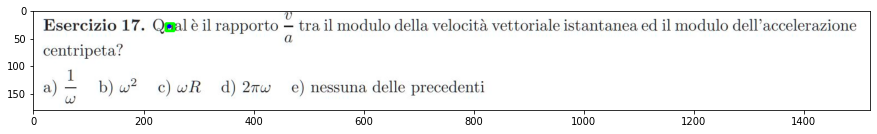

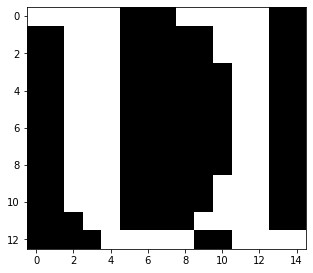

In [354]:
printChar(0, 15)

In [355]:
# Print all chars, set "if True" to execute

if False:
    for i in range(len(centroidsByLine)):
        for j in range(centroidsByLine[i].shape[0]):

            printChar(i, j)

            time.sleep(0.1)
            clear_output(wait=True)
    

Ok, now we have to think a way to merge, remove or change things between 2 adjacent lines.

For instance:
- "i" char is detected as two values (a vertical line and a point above that), therefore we need to merge in a unique value.
- Accents sometimes are detected in a different line, but regardless this is important to join in a unique value
- fractions are another point important to treat


Ok, now we examinate if there is a way to merge accents and the point above the i chars. Using img0

[INFO] Examining row 1 and component 39/116.
Area=121
Centroids 564.6611570247934, 30.15702479338843
y=24, x=553, w=24, h=13


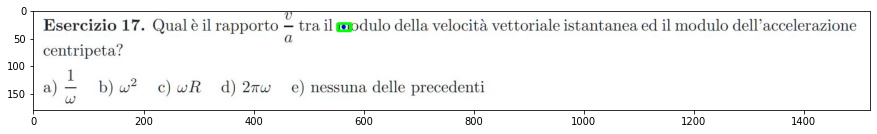

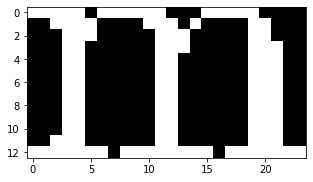

[INFO] Examining row 1 and component 40/116.
Area=68
Centroids 583.8823529411765, 30.0
y=23, x=578, w=13, h=14


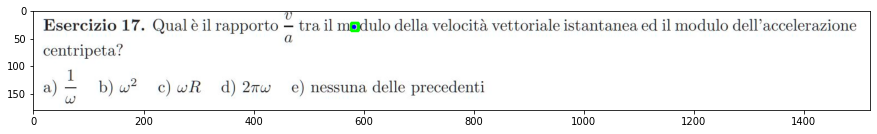

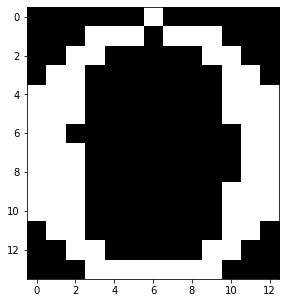

[INFO] Examining row 1 and component 41/116.
Area=108
Centroids 601.9722222222222, 27.36111111111111
y=16, x=594, w=15, h=21


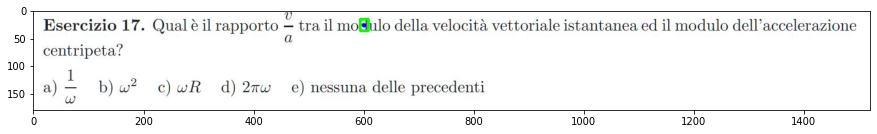

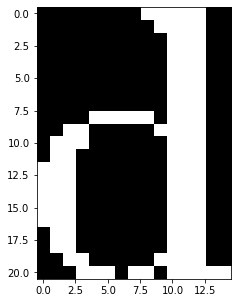

In [356]:
# i-th line, j-char

# img 0
# accents problem
printChar(0, 39)
printChar(0, 40)
printChar(0, 41)

[INFO] Examining row 1 and component 5/116.
Area=17
Centroids 104.6470588235294, 18.0
y=16, x=103, w=5, h=5


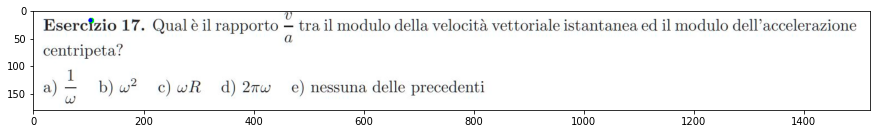

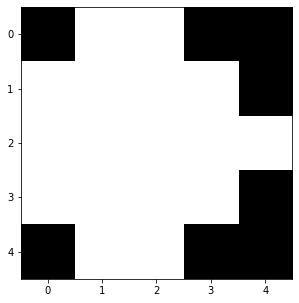

[INFO] Examining row 1 and component 6/116.
Area=53
Centroids 104.86792452830188, 30.11320754716981
y=23, x=102, w=7, h=14


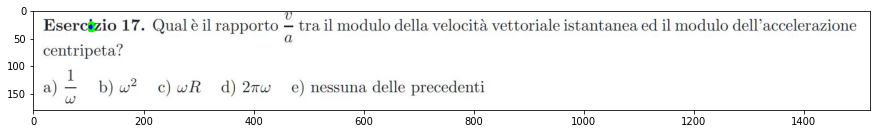

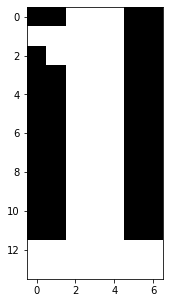

[INFO] Examining row 1 and component 36/116.
Area=9
Centroids 531.6666666666666, 18.11111111111111
y=17, x=530, w=4, h=3


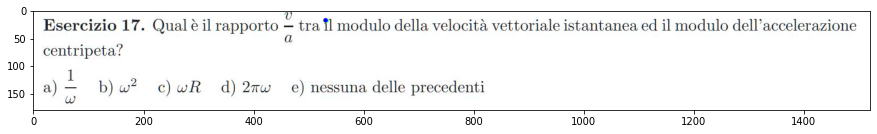

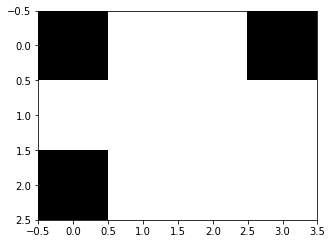

[INFO] Examining row 1 and component 37/116.
Area=36
Centroids 532.1111111111111, 30.333333333333332
y=24, x=529, w=7, h=13


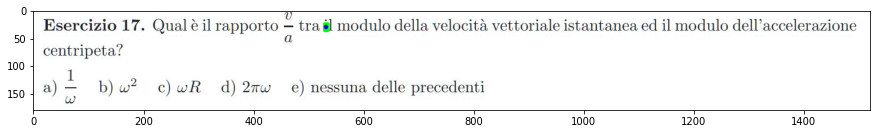

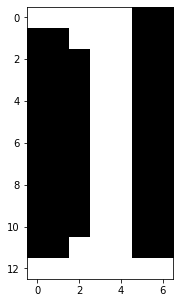

In [357]:
# i-th line, j-char

# img 0
# "i" problem

printChar(0, 5)
printChar(0, 6)

printChar(0, 36)
printChar(0, 37)

[INFO] Examining row 1 and component 34/116.
Area=54
Centroids 498.77777777777777, 29.5
y=24, x=495, w=10, h=13


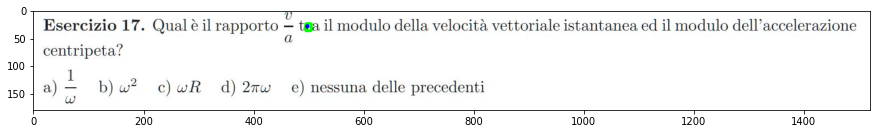

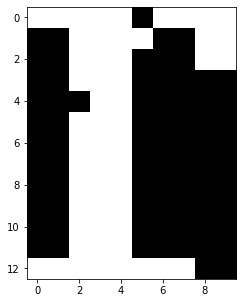

[INFO] Examining row 1 and component 35/116.
Area=69
Centroids 513.536231884058, 30.463768115942027
y=23, x=508, w=13, h=15


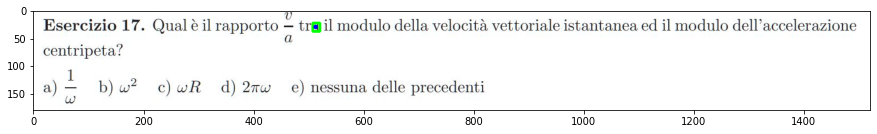

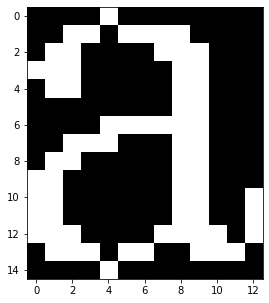

In [358]:
# i-th line, j-char

# img 0
# c problem

printChar(0, 34)
printChar(0, 35)


[INFO] Examining row 1 and component 44/116.
Area=68
Centroids 641.8823529411765, 30.191176470588236
y=23, x=635, w=14, h=14


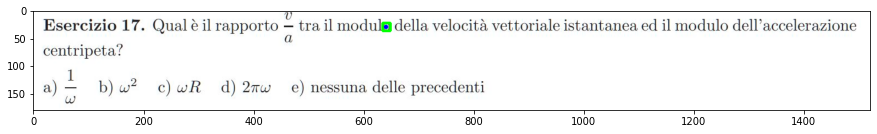

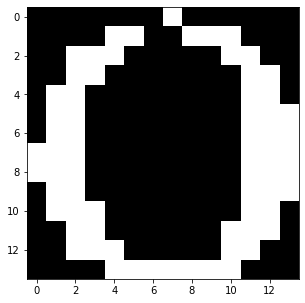

[INFO] Examining row 1 and component 45/116.
Area=88
Centroids 665.1931818181819, 27.647727272727273
y=16, x=658, w=15, h=21


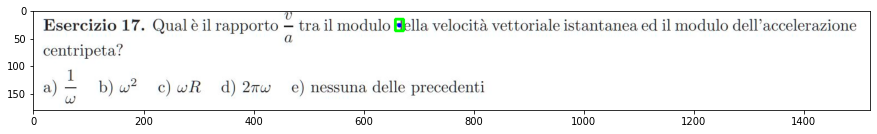

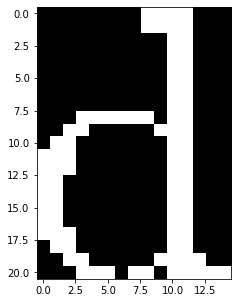

[INFO] Examining row 1 and component 46/116.
Area=67
Centroids 678.9850746268656, 29.776119402985074
y=23, x=674, w=12, h=14


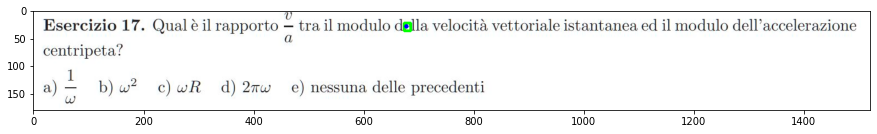

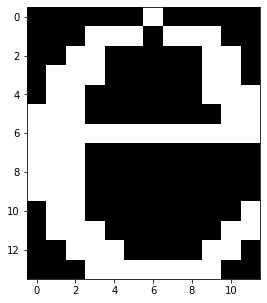

In [359]:
# i-th line, j-char

# img 0
# s problem

printChar(0, 44)
printChar(0, 45)
printChar(0, 46)

In [360]:
def printAllCharsAsPoint():
    output = img.copy()

    for i in range(len(centroidsByLine)):

        for j in range(centroidsByLine[i].shape[0]):
            
            xCurrent = centroidsByLine[i][j][0]
            yCurrent = centroidsByLine[i][j][1]

            cv2.circle(output, (int(xCurrent), int(yCurrent)), 4, (255, 0, 0), -1)

    fig = plt.figure(figsize=(25,25))
    plt.imshow(output, cmap="gray")
    plt.show()

In [361]:
# Let's see the shapes before the process
centroidsByLine[0].shape

(116, 2)

Backward pass

Merge the i-th char with the previous one if:

current_centroids_x - width/2 < current_centroids_x < current_centroids_x + width/2

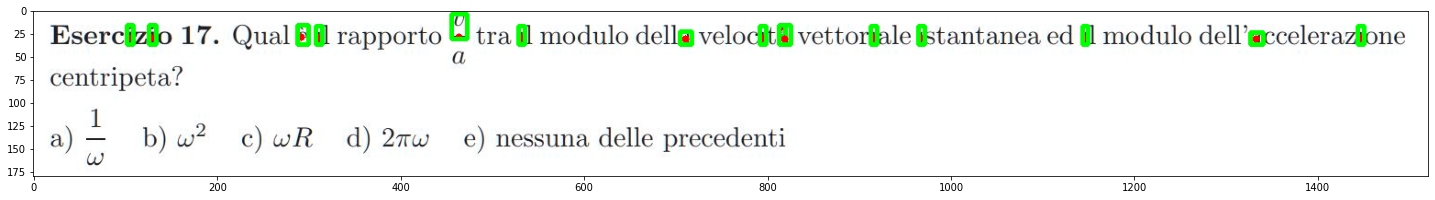

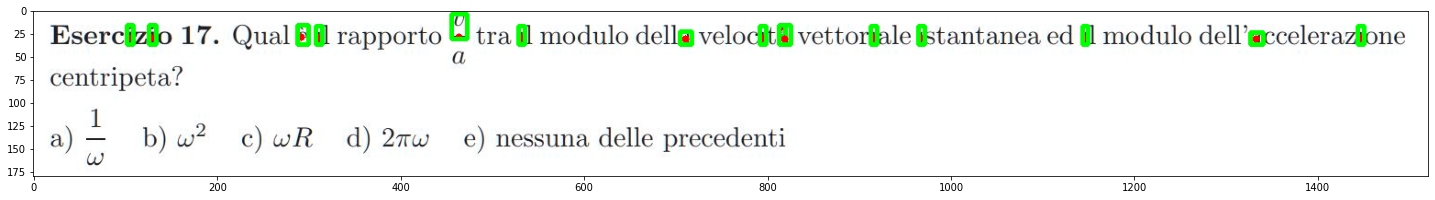

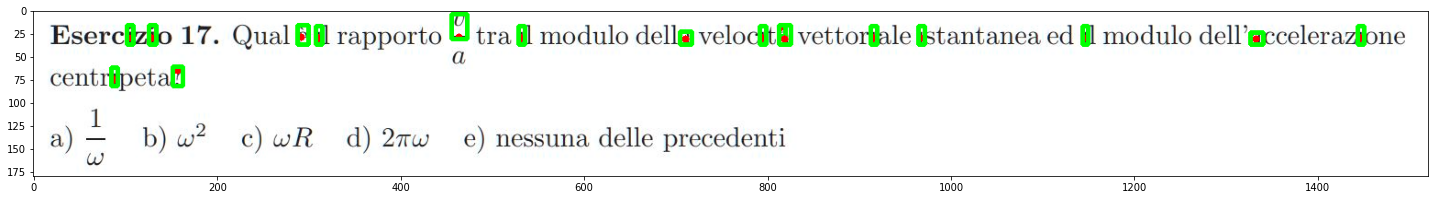

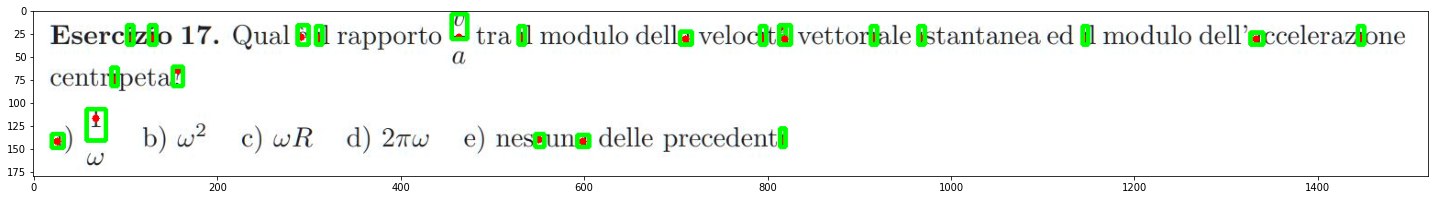

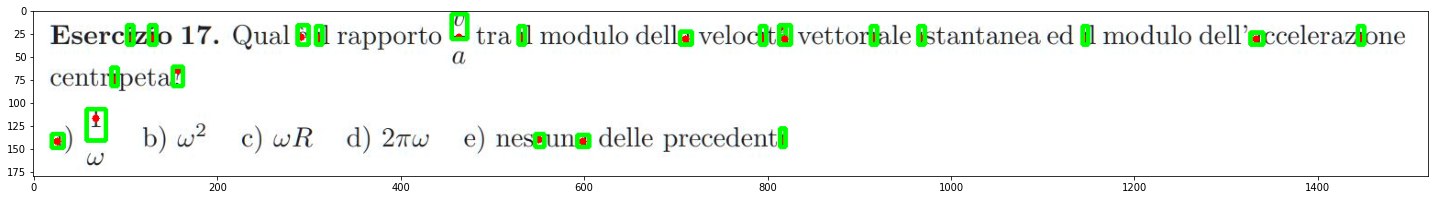

In [362]:
output = img.copy()

for i in range(len(centroidsByLine)):

    centroidsByLineNew = [centroidsByLine[i][0].tolist()]
    statsByLineNew = [statsByLine[i][0].tolist()]

    for j in range(1, centroidsByLine[i].shape[0]):
        
        xPrevious = centroidsByLine[i][j-1][0]
        yPrevious = centroidsByLine[i][j-1][1]
        xCurrent = centroidsByLine[i][j][0]
        yCurrent = centroidsByLine[i][j][1]
        width = statsByLine[i][j][cv2.CC_STAT_WIDTH] / 2

        if xCurrent-width <= xPrevious <= xCurrent+width:
            cv2.circle(output, (int(xCurrent), int(yCurrent)), 4, (255, 0, 0), -1)

            # Merge current and old chars
            yPrevious = statsByLineNew[-1][cv2.CC_STAT_TOP]
            xPrevious = statsByLineNew[-1][cv2.CC_STAT_LEFT]
            yCurrent = statsByLine[i][j][cv2.CC_STAT_TOP]
            xCurrent = statsByLine[i][j][cv2.CC_STAT_LEFT]
            widthPrevious = statsByLineNew[-1][cv2.CC_STAT_WIDTH]
            heightPreivous = statsByLineNew[-1][cv2.CC_STAT_HEIGHT]
            widthCurrent = statsByLine[i][j][cv2.CC_STAT_WIDTH]
            heightCurrent = statsByLine[i][j][cv2.CC_STAT_HEIGHT]

            x = min(xPrevious, xCurrent)
            y = min(yPrevious, yCurrent)

            widthNew = int( max(xPrevious+widthPrevious, xCurrent+widthCurrent) - x )
            heightNew = int( max(yPrevious+heightPreivous, yCurrent+heightCurrent) - y )

            centre = [x + widthNew/2, y + heightNew/2]

            cv2.rectangle(output, (int(x), int(y)), (int(x + widthNew), int(y + heightNew)), (0, 255, 0), 3)

            # Remove the previous point from the lists and append new values
            centroidsByLineNew = centroidsByLineNew[:-1]
            centroidsByLineNew.append(centre)
            statsByLineNew = statsByLineNew[:-1]
            statsByLineNew.append([x,y,widthNew,heightNew, widthNew*heightNew])
            
        else:
            centroidsByLineNew.append(centroidsByLine[i][j].tolist())
            statsByLineNew.append(statsByLine[i][j].tolist())

    # Assign the new list to the i-th line, obviously as numpy object
    centroidsByLine[i] = np.array(centroidsByLineNew)
    statsByLine[i] = np.array(statsByLineNew)

    # Show results
    fig = plt.figure(figsize=(25,25))
    plt.imshow(output, cmap="gray")
    plt.show()

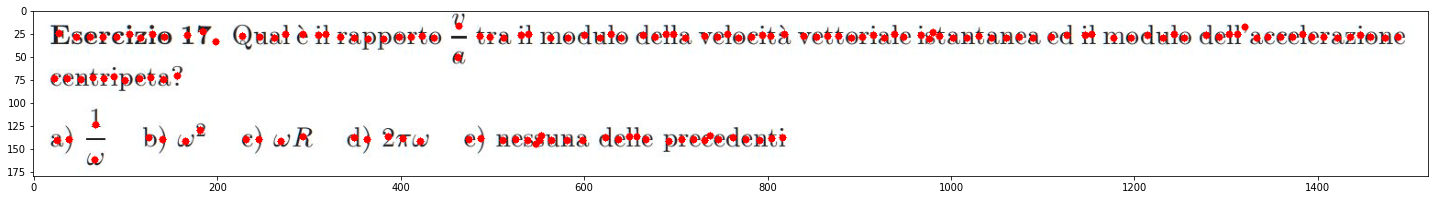

In [363]:
printAllCharsAsPoint()

In [364]:
# Let's see the intermediate level
centroidsByLine[0].shape

(101, 2)

Let's try to see if there are other problems

[INFO] Examining row 1 and component 38/101.
Area=68
Centroids 641.8823529411765, 30.191176470588236
y=23, x=635, w=14, h=14


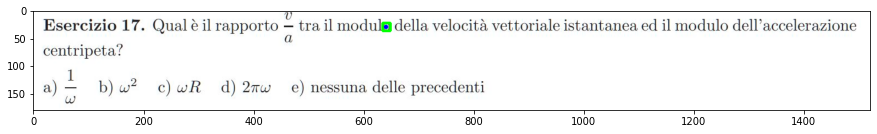

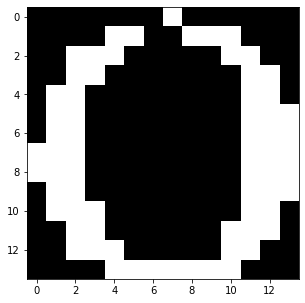

[INFO] Examining row 1 and component 39/101.
Area=88
Centroids 665.1931818181819, 27.647727272727273
y=16, x=658, w=15, h=21


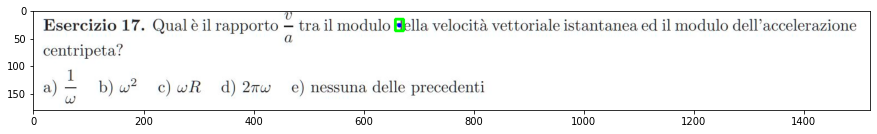

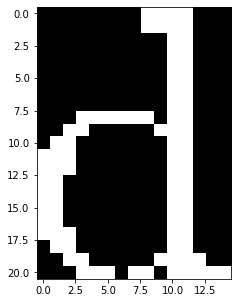

[INFO] Examining row 1 and component 40/101.
Area=67
Centroids 678.9850746268656, 29.776119402985074
y=23, x=674, w=12, h=14


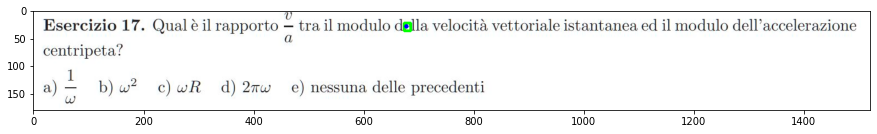

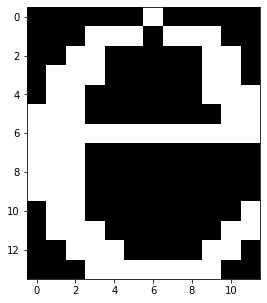

In [365]:
printChar(0, 38)
printChar(0, 39)
printChar(0, 40)

Forward pass

Merge the i-th char with the next one if:

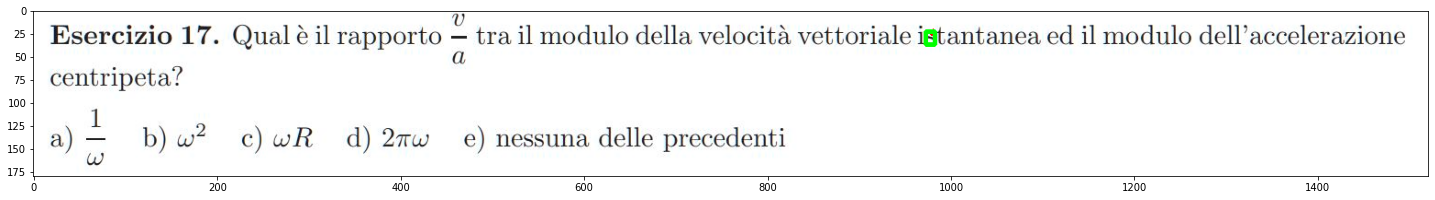

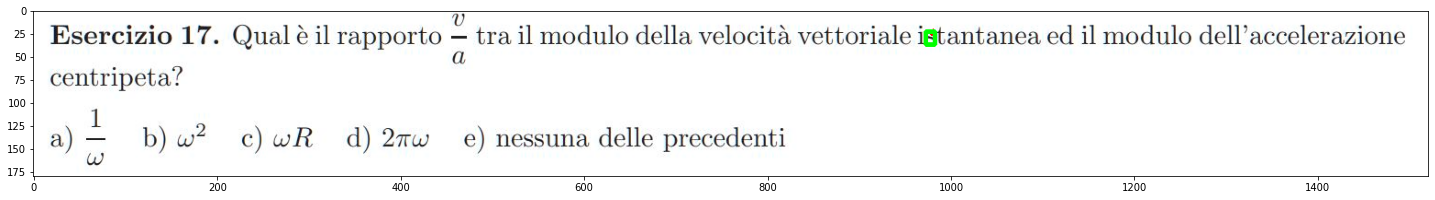

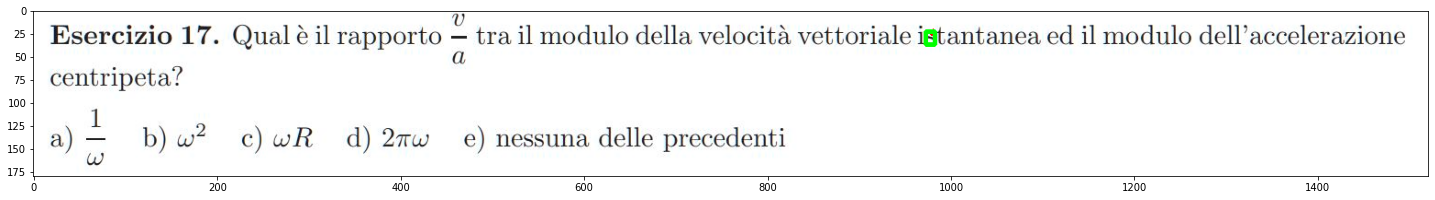

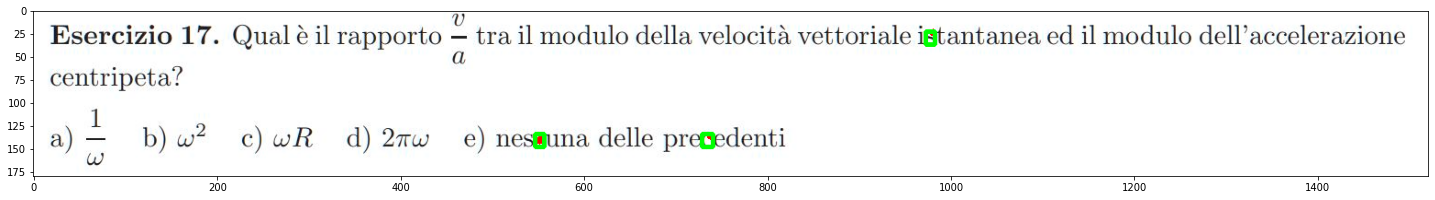

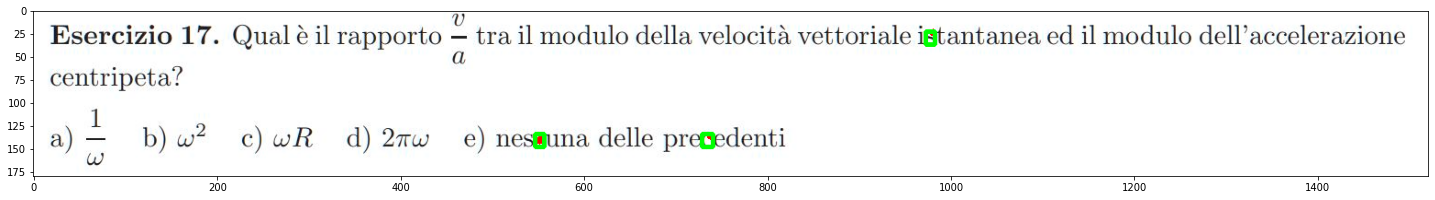

In [366]:
output = img.copy()

for i in range(len(centroidsByLine)):

    centroidsByLineNew = [centroidsByLine[i][0].tolist()]
    statsByLineNew = [statsByLine[i][0].tolist()]

    for j in range(1, centroidsByLine[i].shape[0]):
        
        xPrevious = centroidsByLine[i][j-1][0]
        yPrevious = centroidsByLine[i][j-1][1]
        xCurrent = centroidsByLine[i][j][0]
        yCurrent = centroidsByLine[i][j][1]
        width = statsByLine[i][j-1][cv2.CC_STAT_WIDTH] / 2

        if xPrevious-width-3 <= xCurrent <= xPrevious+width+3: # ATTENTION, YOU USED -3 AND +3, BUT ARE EURISTIC...
            cv2.circle(output, (int(xCurrent), int(yCurrent)), 4, (255, 0, 0), -1)

            # Merge current and old chars
            yPrevious = statsByLineNew[-1][cv2.CC_STAT_TOP]
            xPrevious = statsByLineNew[-1][cv2.CC_STAT_LEFT]
            yCurrent = statsByLine[i][j][cv2.CC_STAT_TOP]
            xCurrent = statsByLine[i][j][cv2.CC_STAT_LEFT]
            widthPrevious = statsByLineNew[-1][cv2.CC_STAT_WIDTH]
            heightPreivous = statsByLineNew[-1][cv2.CC_STAT_HEIGHT]
            widthCurrent = statsByLine[i][j][cv2.CC_STAT_WIDTH]
            heightCurrent = statsByLine[i][j][cv2.CC_STAT_HEIGHT]

            x = min(xPrevious, xCurrent)
            y = min(yPrevious, yCurrent)

            widthNew = int( max(xPrevious+widthPrevious, xCurrent+widthCurrent) - x )
            heightNew = int( max(yPrevious+heightPreivous, yCurrent+heightCurrent) - y )

            centre = [x + widthNew/2, y + heightNew/2]

            cv2.rectangle(output, (int(x), int(y)), (int(x + widthNew), int(y + heightNew)), (0, 255, 0), 3)

            # Remove the previous point from the lists and append new values
            centroidsByLineNew = centroidsByLineNew[:-1]
            centroidsByLineNew.append(centre)
            statsByLineNew = statsByLineNew[:-1]
            statsByLineNew.append([x,y,widthNew,heightNew, widthNew*heightNew])
            
        else:
            centroidsByLineNew.append(centroidsByLine[i][j].tolist())
            statsByLineNew.append(statsByLine[i][j].tolist())

    # Assign the new list to the i-th line, obviously as numpy object
    centroidsByLine[i] = np.array(centroidsByLineNew)
    statsByLine[i] = np.array(statsByLineNew)

    # Show results
    fig = plt.figure(figsize=(25,25))
    plt.imshow(output, cmap="gray")
    plt.show()

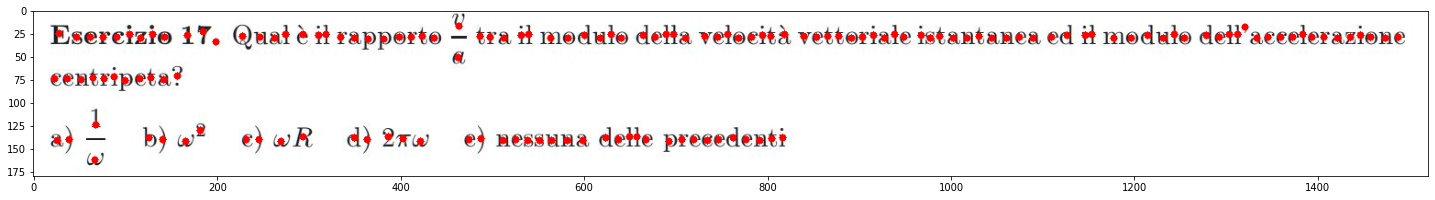

In [367]:
printAllCharsAsPoint()

In [368]:
centroidsByLine[0].shape

(100, 2)

Let's try to find the group of words

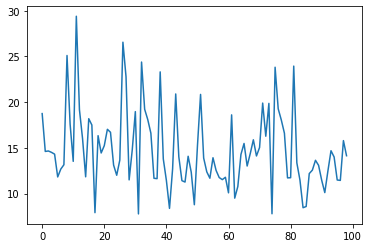

In [369]:
# Get distances between chars using centroids
dist = np.diff(centroidsByLine[0], axis=0)[:,0]

plt.plot(np.abs(dist))

Mmm, with the previous method there is too noise

In [370]:
# Let's try somenthing better using stat_left and right
# Get distances between chars. 
# i is the i-th line

def getDistChars(i):
    right = (statsByLine[i][:,0] + statsByLine[i][:,2])[:-1]
    dist = np.abs( right - statsByLine[i][1:,0] )
    
    return dist, right

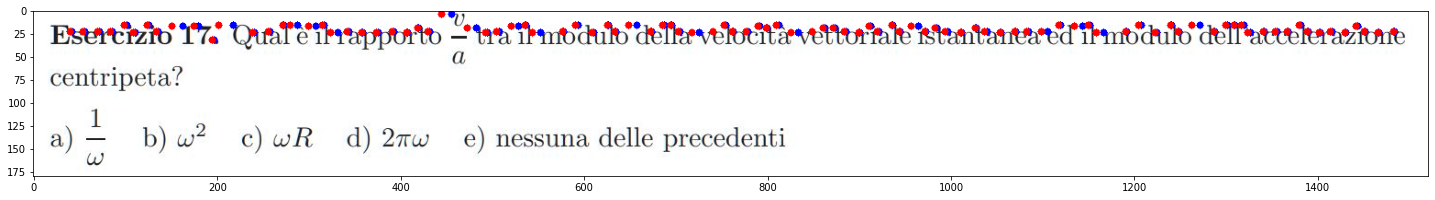

In [371]:
# Let's see what we actually comparing during the process

output = img.copy()

dist, right = getDistChars(0)

for i, val in enumerate(statsByLine[0][1:]):
    x = val[cv2.CC_STAT_TOP]
    y = val[cv2.CC_STAT_LEFT]
    cv2.circle(output, (y, x), 4, (0, 0, 255), -1) # blue

    yn = right[i]
    cv2.circle(output, (yn, x), 4, (255, 0, 0), -1) #red

    #print(yn-y)

fig = plt.figure(figsize=(25,25))
plt.imshow(output, cmap="gray")
plt.show()

3.0


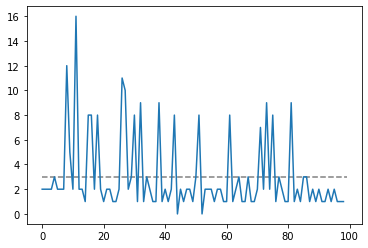

In [372]:
# Print mean value of the first line
def computeAutoThresh(dist):
    if dist.shape[0] != 0:
        autoThresh = np.ceil(dist.mean())
        print(autoThresh)
        plt.hlines(y=autoThresh, xmin=0, xmax=len(dist), colors='gray', linestyles='--')
        plt.plot(dist)
        plt.show()
        return autoThresh
    else:
        return dist[0]

autoThresh = computeAutoThresh(dist)

3.0


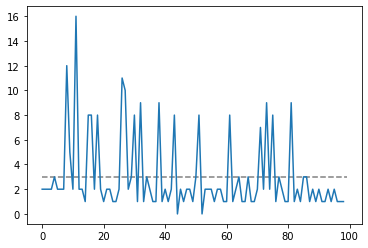

2.0


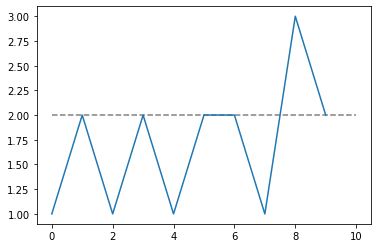

8.0


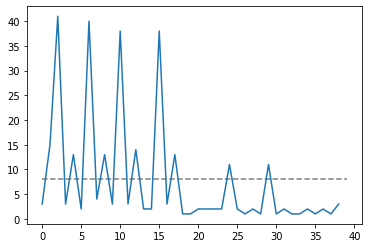

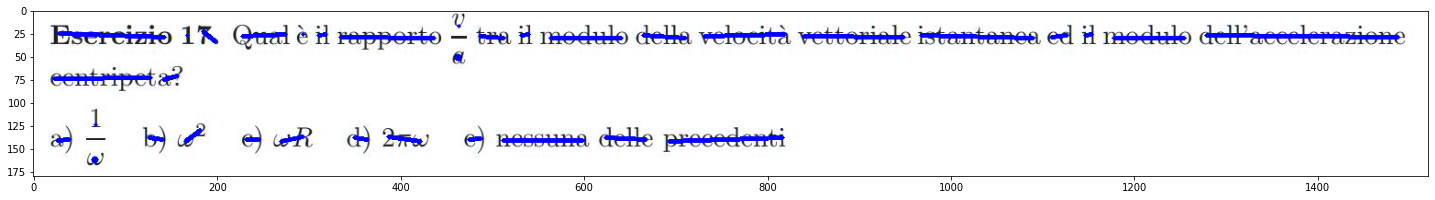

In [373]:
output = img.copy()

for j in range(len(centroidsByLine)):
    startP = centroidsByLine[j][0]

    dist, right = getDistChars(j)

    if dist.shape[0] != 0:
        autoThresh = computeAutoThresh(dist)       

        for i, val in enumerate(dist):

            if val > autoThresh:
                cv2.line(output, (int(startP[0]), int(startP[1])), ( int(centroidsByLine[j][i][0]), int(centroidsByLine[j][i][1])), (0, 0, 255), thickness=3)
                startP = centroidsByLine[j][i+1]

        cv2.line(output, (int(startP[0]), int(startP[1])), ( int(centroidsByLine[j][-1][0]), int(centroidsByLine[j][-1][1])), (0, 0, 255), thickness=3)

    else:
        cv2.circle(output, (int(startP[0]), int(startP[1])), 4, (0, 0, 255), -1) # blue

fig = plt.figure(figsize=(25,25))
plt.imshow(output, cmap="gray")
plt.show()